In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#based of https://www.tensorflow.org/tutorials/load_data/images
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import re
import pathlib
from keras.callbacks import ModelCheckpoint

path = "/content/drive/MyDrive/fabric_classification/Fabrics_simple"

data_dir = pathlib.Path(path)

In [3]:
batch_size = 32
img_height = 400
img_width = 400
img_size = (img_height, img_width)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 1008 files belonging to 2 classes.
Using 807 files for training.
Found 1008 files belonging to 2 classes.
Using 201 files for validation.
['Denim', 'Wool']


In [14]:
#the augmentations to make
data_augmentation = tf.keras.Sequential(
    [
        #tf.keras.layers.RandomFlip("horizontal"),
        #tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.5)
    ]
)

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [15]:
#based of https://www.tensorflow.org/tutorials/load_data/images
num_classes = 2

# attempt 1 with norm = 0.00005
# attempt 2 with norm = 0.0005
# attempt 3 with norm = 0.005
# attempt 4 with norm = 0.05
norm = 0.005

model = tf.keras.Sequential([
  data_augmentation,#comment out to remove data augmentation
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, input_shape=(32, 400, 400, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(norm)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(norm)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(norm)),
  
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

#based on https://towardsdatascience.com/ai-for-textiles-convolutional-neural-network-based-fabric-structure-classifier-c0db5433501d
checkpoint = ModelCheckpoint(filepath = 's_model_NoAug_NoOptv3.h5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

hist = model.fit(
    train_ds, 
    validation_data = val_ds, 
    epochs = 50, 
    verbose = 1, 
    callbacks = [checkpoint])

model.summary()

Epoch 1/50
25/26 [===========================>..] - ETA: 0s - loss: 1.7505 - accuracy: 0.5850
Epoch 1: val_accuracy improved from -inf to 0.64179, saving model to s_model_NoAug_NoOptv3.h5
26/26 [==============================] - 3s 88ms/step - loss: 1.7453 - accuracy: 0.5849 - val_loss: 1.2027 - val_accuracy: 0.6418
Epoch 2/50
25/26 [===========================>..] - ETA: 0s - loss: 1.0740 - accuracy: 0.6650
Epoch 2: val_accuracy improved from 0.64179 to 0.70149, saving model to s_model_NoAug_NoOptv3.h5
26/26 [==============================] - 2s 83ms/step - loss: 1.0734 - accuracy: 0.6642 - val_loss: 0.9323 - val_accuracy: 0.7015
Epoch 3/50
25/26 [===========================>..] - ETA: 0s - loss: 0.9020 - accuracy: 0.6500
Epoch 3: val_accuracy did not improve from 0.70149
26/26 [==============================] - 2s 74ms/step - loss: 0.8997 - accuracy: 0.6518 - val_loss: 1.1594 - val_accuracy: 0.5323
Epoch 4/50
25/26 [===========================>..] - ETA: 0s - loss: 0.9072 - accuracy:

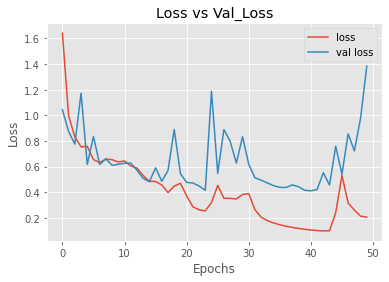

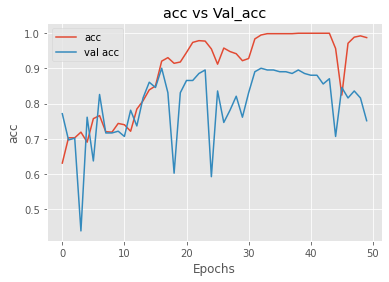

In [13]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label = 'acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

(201, 2)
(201,)
(201,)
[[136   4]
 [ 14  47]]


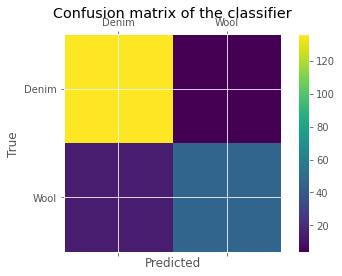

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

y_pred = model.predict(val_ds)#X
predicted_categories = tf.argmax(y_pred, axis=1)#X
true_categories = tf.concat([y for x, y in val_ds], axis=0)#y

print(y_pred.shape)
print(predicted_categories.shape)
print(true_categories.shape)

cm = confusion_matrix(true_categories, predicted_categories)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()